# CityBikes

### Send a request to CityBikes for the city of your choice. 

In [21]:
# Importing libraries
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [22]:
# Sending first request to CityBikes API
response = requests.get('http://api.citybik.es/v2/networks')

In [23]:
# Viewing message to ensure the request was successful.  If message code is 200 then it was successful.
response

<Response [200]>

In [24]:
# Viewing the response to see what fields it contains
response.json()

{'networks': [{'company': ['ЗАО «СитиБайк»'],
   'href': '/v2/networks/velobike-moscow',
   'id': 'velobike-moscow',
   'location': {'city': 'Moscow',
    'country': 'RU',
    'latitude': 55.75,
    'longitude': 37.616667},
   'name': 'Velobike'},
  {'company': ['Urban Infrastructure Partner'],
   'href': '/v2/networks/baerum-bysykkel',
   'id': 'baerum-bysykkel',
   'location': {'city': 'Bærum',
    'country': 'NO',
    'latitude': 59.89455,
    'longitude': 10.546343},
   'name': 'Bysykkel'},
  {'company': ['Comunicare S.r.l.'],
   'href': '/v2/networks/bicincitta-siena',
   'id': 'bicincitta-siena',
   'location': {'city': 'Siena',
    'country': 'IT',
    'latitude': 43.3186,
    'longitude': 11.3306},
   'name': 'Bicincittà',
   'source': 'https://www.bicincitta.com/frmLeStazioni.aspx?ID=202'},
  {'company': ['Cyclopolis Systems'],
   'href': '/v2/networks/cyclopolis-maroussi',
   'id': 'cyclopolis-maroussi',
   'location': {'city': 'Maroussi',
    'country': 'GR',
    'latitude':

In [25]:
# Creating the networks dataframe
df_networks = pd.DataFrame.from_dict(response.json())
df_networks.head()

,networks
0,"{'company': ['ЗАО «СитиБайк»'], 'href': '/v2/n..."
1,"{'company': ['Urban Infrastructure Partner'], ..."
2,"{'company': ['Comunicare S.r.l.'], 'href': '/v..."
3,"{'company': ['Cyclopolis Systems'], 'href': '/..."
4,"{'company': ['Groundwork', 'Slough Borough Cou..."


In [26]:
# All of the data is nested within the 'network' column, so this needs to be unnested using pd.json_normalize()
df_networks = pd.json_normalize(df_networks['networks'])
df_networks.head()

,company,href,id,name,location.city,location.country,location.latitude,location.longitude,source,gbfs_href,license.name,license.url,ebikes
0,[ЗАО «СитиБайк»],/v2/networks/velobike-moscow,velobike-moscow,Velobike,Moscow,RU,55.750000,37.616667,NaN,NaN,NaN,NaN,NaN
1,[Urban Infrastructure Partner],/v2/networks/baerum-bysykkel,baerum-bysykkel,Bysykkel,Bærum,NO,59.894550,10.546343,NaN,NaN,NaN,NaN,NaN
2,[Comunicare S.r.l.],/v2/networks/bicincitta-siena,bicincitta-siena,Bicincittà,Siena,IT,43.318600,11.330600,https://www.bicincitta.com/frmLeStazioni.aspx?...,NaN,NaN,NaN,NaN
3,[Cyclopolis Systems],/v2/networks/cyclopolis-maroussi,cyclopolis-maroussi,Cyclopolis,Maroussi,GR,38.056872,23.808330,NaN,NaN,NaN,NaN,NaN
4,"[Groundwork, Slough Borough Council, ITS]",/v2/networks/cycle-hire-slough,cycle-hire-slough,Cycle Hire,Slough,GB,51.511350,-0.591562,NaN,NaN,NaN,NaN,NaN


In [27]:
# I have chosen Phoenix, AZ for the city.  Finding 'href' for Phoenix, AZ.
href_phx = df_networks[df_networks['location.city'].str.contains('Phoenix')]['href'].iloc[0]
print(href_phx)

/v2/networks/grid-bike-share


In [28]:
# Ensuring only one city is connected to href
df_networks[df_networks['href'].str.contains('/v2/networks/grid-bike-share')]['location.city'].value_counts()

location.city
Phoenix, AZ    1
Name: count, dtype: int64

### Parse through the response to get the details you want for the bike stations in that city (latitude, longitude, number of bikes). 

In [29]:
# Sending request to CutyBike API to get bike station data
fields = 'stations'
response_phx = requests.get('http://api.citybik.es' + href_phx + '?fields=' + fields)

In [30]:
# Confirming request was successful.  Message code 200 means it was.
response_phx

<Response [200]>

In [31]:
# Veiwing the response
response_phx.json()

{'network': {'stations': [{'empty_slots': 9,
    'extra': {'address': '6135-6193 South All America Way, Tempe',
     'last_updated': 1613119143,
     'renting': 1,
     'returning': 1,
     'uid': 'hub_3779'},
    'free_bikes': 0,
    'id': 'd334f65221f6a681f8b03433f36e2075',
    'latitude': 33.36648847067389,
    'longitude': -111.93561159074306,
    'name': 'T19 Kiwanis Park',
    'timestamp': '2021-02-12T08:38:15.409000Z'},
   {'empty_slots': 6,
    'extra': {'address': 'North 10th Street, Garfield, Central City, Phoenix, Arizona',
     'last_updated': 1613119143,
     'renting': 1,
     'returning': 1,
     'uid': 'hub_4255'},
    'free_bikes': 0,
    'id': 'cac663c57dee1dafd5f152bb906e97d5',
    'latitude': 33.45565436717689,
    'longitude': -112.06059247255325,
    'name': 'P211 10th St / Pierce',
    'timestamp': '2021-02-12T08:38:15.412000Z'},
   {'empty_slots': 9,
    'extra': {'address': '1021 North 2nd Street, Phoenix',
     'last_updated': 1613119143,
     'renting': 1,
  

### Put your parsed results into a DataFrame.

In [32]:
# Create initial Phoenix bike stations dataframe
df_stations_initial = pd.DataFrame.from_dict(response_phx.json())

# Data is nested in a list of dicts, need to use df.explode() to separate into different rows.  Also need to reset the index.
df_stations_initial = df_stations_initial.explode('network').reset_index(drop=True)
df_stations_initial.head()

,network
0,"{'empty_slots': 9, 'extra': {'address': '6135-..."
1,"{'empty_slots': 6, 'extra': {'address': 'North..."
2,"{'empty_slots': 9, 'extra': {'address': '1021 ..."
3,"{'empty_slots': 23, 'extra': {'address': '2-98..."
4,"{'empty_slots': 6, 'extra': {'address': '650 E..."


In [33]:
# Normalizing json data to separate fields into different columns
df_stations = pd.json_normalize(df_stations_initial['network'])
df_stations.head()

,empty_slots,free_bikes,id,latitude,longitude,name,timestamp,extra.address,extra.last_updated,extra.renting,extra.returning,extra.uid
0,9,0,d334f65221f6a681f8b03433f36e2075,33.366488,-111.935612,T19 Kiwanis Park,2021-02-12T08:38:15.409000Z,"6135-6193 South All America Way, Tempe",1613119143,1,1,hub_3779
1,6,0,cac663c57dee1dafd5f152bb906e97d5,33.455654,-112.060592,P211 10th St / Pierce,2021-02-12T08:38:15.412000Z,"North 10th Street, Garfield, Central City, Pho...",1613119143,1,1,hub_4255
2,9,0,8d29ea89964d1eb73171310f718fe7e5,33.458995,-112.071128,P196 2nd St. and Roosevelt,2021-02-12T08:38:15.415000Z,"1021 North 2nd Street, Phoenix",1613119143,1,1,hub_3525
3,23,0,6628d10945695a8a19a0ede32f949bc4,33.429720,-111.940602,T17 Tempe Beach Park,2021-02-12T08:38:15.416000Z,"2-98 West Rio Salado Parkway, Tempe",1613119143,1,1,hub_2458
4,6,0,b953cdb6c1721e12c870e32cb780998c,33.420541,-111.930670,ASU Goldwater Ctr. for Science - Tyler Mall (V...,2021-02-12T08:38:15.417000Z,"650 East Tyler Mall, Tempe",1613119143,1,1,hub_5266


In [34]:
# Adding total bikes column
df_stations['total_bikes'] = df_stations['empty_slots'] + df_stations['free_bikes']

## Exploratory Data Analysis

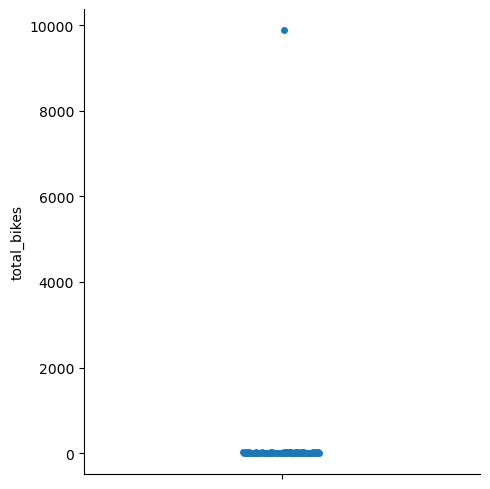

In [19]:
# Vizualizing 'total_bikes' values on a cat plot.  There is one significant outlier.
sns.catplot(data=df_stations, y ='total_bikes')

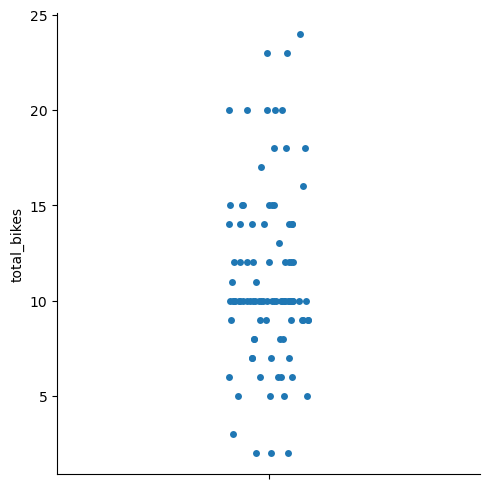

In [41]:
# Dropping the outlier will make for better analysis
df_stations = df_stations[df_stations['total_bikes']<1000]

sns.catplot(data=df_stations, y ='total_bikes')

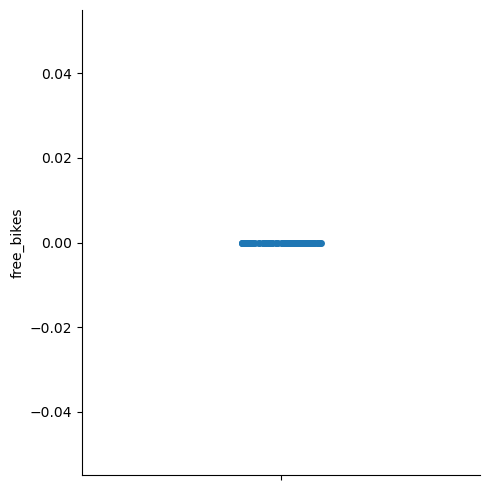

In [37]:
# Visualizing 'free_bikes' values on a cat plot.  All values are zero.
sns.catplot(data=df_stations, y ='free_bikes')

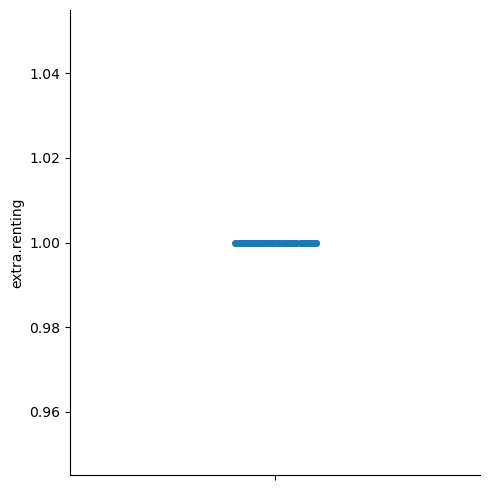

In [38]:
# Vizualizing 'extra.renting' values on a cat plot.  All values are equal to 1.
sns.catplot(data=df_stations, y ='extra.renting')

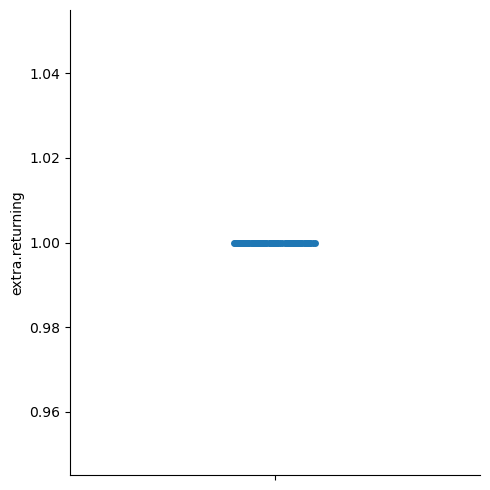

In [39]:
# Vizualizing 'extra.returning' values on a cat plot.  All values are equal to 1.
sns.catplot(data=df_stations, y ='extra.returning')

<Axes: xlabel='longitude', ylabel='latitude'>

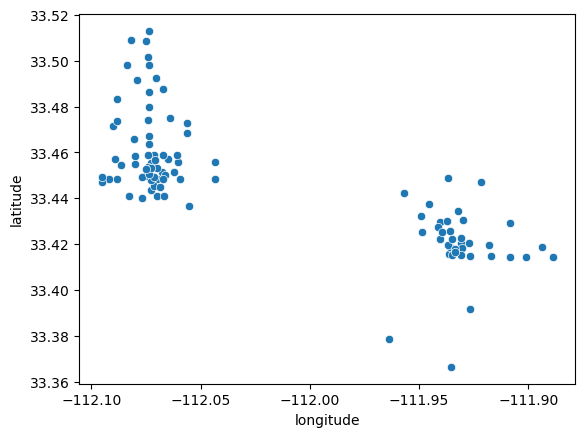

In [40]:
# Vizualizing 'longitude' and 'latitude' values on a scatter plot. There are 3 moderate outliers in the southeast, 
# but the results match the map on the CityBike website so I will leave them in.
sns.scatterplot(data=df_stations, x = 'longitude', y ='latitude')

In [42]:
# Saving dataframe to csv
df_stations.to_csv(path_or_buf='df_stations.csv',index=False)